##  Object based multi-channel colocalisation for chain like structures

We here demonstate how to use the package `multi_match` to perform a multi-channel object based colocalisation analysis and detect chain like structures in a three channel micrsocopy image. The analysis contains the following steps:
- We load the three channels 
- We use a blob detection algorithm to detect the flourecent markers in the image
- We set an interaction radius and detect chain like structures 
- We visualize the results and estimate true abundances assuming a given that some protein structures are not detected/stained with a given probability.

In [1]:
import matplotlib.pyplot as plt
from skimage import io
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as patches
import numpy as np

# imports from multi_match
from multi_match.colorify import multichannel_to_rgb
import multi_match

In [2]:
# First we read some example images and set the pixel to nanometer ratio

data_folder = "/home/tnies/multi_match/examples/example_data/"
image_A = io.imread(data_folder + 'STAR RED_STED {7}.tif')
image_B = io.imread(data_folder + 'Alexa 488_STED {12}.tif')
image_C = io.imread(data_folder + 'Alexa 594_STED {7}.tif')

pixel_per_nanometer = 0.04
nanometer_per_pixel = 1/pixel_per_nanometer

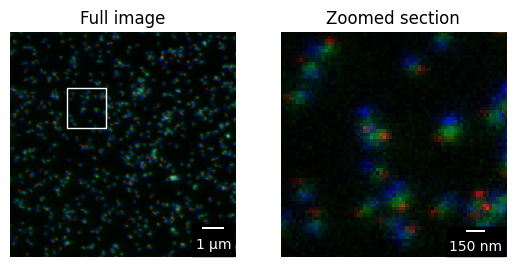

In [3]:
zoom_rect_corner = [100, 100]
width_zoom = 70
hight_zoom = 70

fig, (ax0, ax1) = plt.subplots(1, 2)
#$ plt.ioff()
cmaps=['pure_red','pure_green', 'pure_blue']

# Create a Rectangle patch
rect = patches.Rectangle(zoom_rect_corner, width_zoom, hight_zoom, linewidth=1, edgecolor='white', facecolor='none')
ax1.set_xlim([zoom_rect_corner[0], zoom_rect_corner[0] + width_zoom])
ax1.set_ylim([zoom_rect_corner[1], zoom_rect_corner[1] + hight_zoom])
ax0.set_title("Full image")
ax1.set_title("Zoomed section")
# Add the patch to the Axes
ax0.add_patch(rect)
background_image, _, __ = multichannel_to_rgb(images=[image_A, image_B, image_C], cmaps=cmaps)
for ax in (ax0, ax1):
                                              
    ax.imshow(background_image)
    ax.axis("off")
    scalebar = ScaleBar(pixel_per_nanometer,
        "nm",
        length_fraction=0.10,
        box_color="black",
        color="white",
        location="lower right")
    scalebar.dx = 25
    ax.add_artist(scalebar)
    # we can chose to focus only on a section of the image by setting the limits

plt.show()


In [4]:
# We now can perform a point detection
x = multi_match.point_detection(image_A)
y = multi_match.point_detection(image_B)
z = multi_match.point_detection(image_C)


# And find the matching within a certain distance

maximum_interaction_distance = 100 * pixel_per_nanometer # distance in pixel
match = multi_match.Multi_Matching([x, y, z], maximum_interaction_distance)

The result of the point detection is illustrated bellow, followed by the chain like structures found.

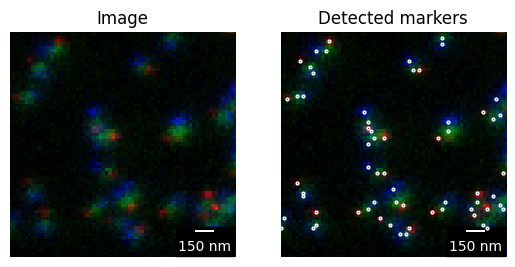

In [5]:
fig, (ax0, ax1) = plt.subplots(1, 2)

colors = ["tab:red", "tab:green", "tab:blue"]
match.plot_marginals(ax1, channel_colors=colors, edgecolors="white", size=4)


# Create a Rectangle patch

ax0.set_title("Image")
ax1.set_title("Detected markers")

for ax in (ax0, ax1):
    ax.set_xlim([zoom_rect_corner[0], zoom_rect_corner[0] + width_zoom])
    ax.set_ylim([zoom_rect_corner[1], zoom_rect_corner[1] + hight_zoom])
                                           
    ax.imshow(background_image)
    ax.axis("off")
    scalebar = ScaleBar(0.04,
        "nm",
        length_fraction=0.10,
        box_color="black",
        color="white",
        location="lower right")
    scalebar.dx = 25
    ax.add_artist(scalebar)
    # we can chose to focus only on a section of the image by setting the limits 

plt.show()


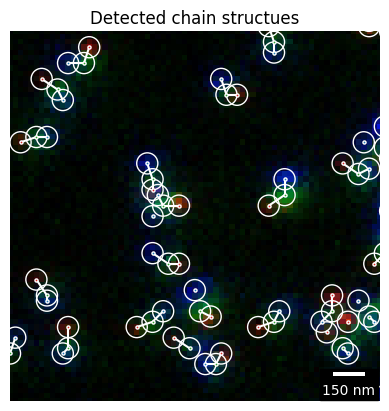

In [6]:
fig, ax = plt.subplots()

# Create a Rectangle patch

ax.set_title("Detected chain structues")

match.plot_match(channel_colors=colors, circle_color="white",
                 segment_color="white", circle_alpha=1, scatter_edgecolors="white", scatter_size=5)

ax.set_xlim([zoom_rect_corner[0], zoom_rect_corner[0] + width_zoom])
ax.set_ylim([zoom_rect_corner[1], zoom_rect_corner[1] + hight_zoom])
                                           
ax.imshow(background_image)
ax.axis("off")
scalebar = ScaleBar(0.04,
        "nm",
        length_fraction=0.10,
        box_color="black",
        color="white",
        location="lower right")
scalebar.dx = 25
ax.add_artist(scalebar)


plt.show()

We can now count the abundances of each type of object. n_ABC is the number of triplets found, n_AB is the number of pairs between the first and the second channel, and n_BC is the number of pairs between the second and the third channel. The values n_A, n_B and n_C are the points that were not matched for each channel.

In [7]:
W = match.count_objects()

for key, value in W.items():
    print(key, ' : ', value)


w_ABC  :  376
w_AB  :  115
w_BC  :  135
w_A  :  146
w_B  :  24
w_C  :  172


Given a staining efficiency value for each channel, we can also estimate the true abbundances, accounting for unstained protein structures.

In [8]:
s_a, s_b, s_c = 0.9, 0.9, 0.9
N = match.estimate_abundances([s_a, s_b, s_c])

for key, value in N.items():
    print(key, ' : ', value)

n_ABC  :  516
n_AB  :  90
n_BC  :  115
n_A  :  102
n_B  :  1
n_C  :  128


We can also visualize the abundances over a range of maximal iteraction distance values.

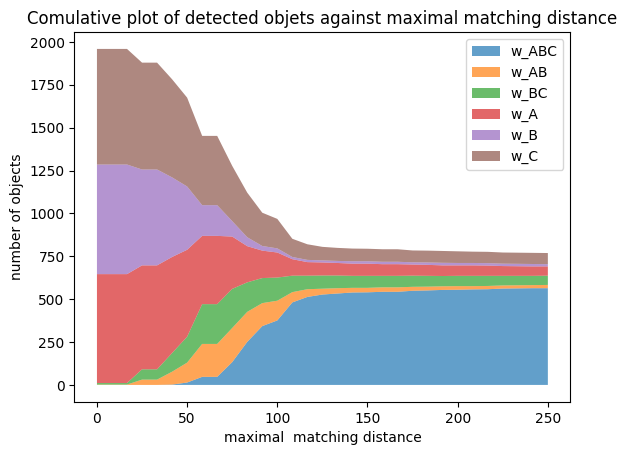

In [9]:
# set a range of maximal matching distance values
maxdist_range = np.linspace(0, 250, num=31) 
(xn, yn, zn) = [p * nanometer_per_pixel for p in [x, y, z]]
mmr = multi_match.Multi_Matching_Over_Range((xn, yn, zn), maxdist_range)
mmr.plot_number_of_objects()




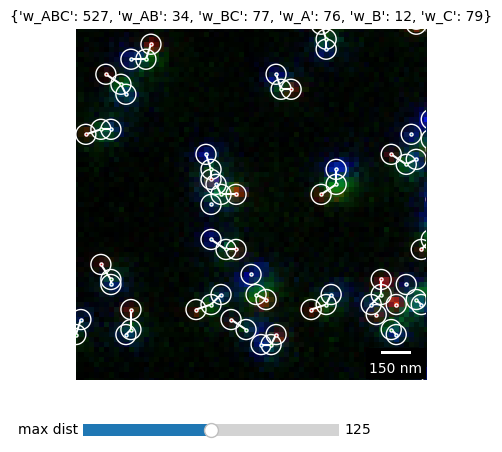

In [10]:
fig, ax = plt.subplots()

# Create a Rectangle patch

ax.set_title("Detected chain structues")

match.plot_match(channel_colors=colors, circle_color="white",
                 segment_color="white", circle_alpha=1, scatter_edgecolors="white", scatter_size=5)

ax.set_xlim([zoom_rect_corner[0], zoom_rect_corner[0] + width_zoom])
ax.set_ylim([zoom_rect_corner[1], zoom_rect_corner[1] + hight_zoom])
                                           
ax.imshow(background_image)
ax.axis("off")
scalebar = ScaleBar(0.04,
        "nm",
        length_fraction=0.10,
        box_color="black",
        color="white",
        location="lower right")
scalebar.dx = 25
ax.add_artist(scalebar)
mmr.plot_match()